# CryoCRAB Preprocess

This is a general preprocessing script to greatly enhance contrast of noisy cryo-EM micrograph, which involves background subtraction.

In [1]:
import pyfftw
import sys, os
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"{project_root = }")
from CryoCRAB import *
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger("pymongo").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("h5py").setLevel(logging.WARNING)
logging.getLogger("numba").setLevel(logging.WARNING)
import mrcfile
import numpy as np
import matplotlib.pyplot as plt

project_root = '/home/vrlab/code/Cryo/CryoCRAB-Scripts'
/home/vrlab/code/Cryo/CryoCRAB-Scripts


## Prepare Test Data & Metadata

In [2]:
# micrograph_path = "/home/vrlab/code/Cryo/CryoCRAB-Scripts/Data/052261_empiar_10757_full.mrc"
# background_path = "/home/vrlab/code/Cryo/CryoCRAB-Scripts/Data/052261_empiar_10757_background.mrc"
# defocus_u = 12069.91015625
# defocus_v = 11055.6884765625
# defocus_angle_rad = 0.36619406938552856
# accel_kv = 300
# cs_mm = 2.7
# amp_contrast = 0.1
# phase_shift_rad = 0
# psize_in = 0.843

micrograph_path = "/home/vrlab/code/Cryo/CryoCRAB-Scripts/Data/095637_empiar_11246_full.mrc"
background_path = "/home/vrlab/code/Cryo/CryoCRAB-Scripts/Data/095637_empiar_11246_background.mrc"
defocus_u = 25355.927734375
defocus_v = 25265.197265625
defocus_angle_rad = -0.2030562311410904
accel_kv = 300
cs_mm = 2.7
amp_contrast = 0.1
phase_shift_rad = 0
psize_in = 0.86


In [3]:
# bin1 micrograph without background
with mrcfile.open(micrograph_path, mode='r', permissive=True) as mrc:
    mic_bin1_noBG = mrc.data.copy().astype(np.float32)
frame_shape_in = mic_bin1_noBG.shape # order: ny, nx
print(f"{frame_shape_in = }")
# 1024x1024 estimated background
with mrcfile.open(background_path, mode='r', permissive=True) as mrc:
    BG_bin = mrc.data.copy().astype(np.float32)
BG_bin_shape = BG_bin.shape
print(f"{BG_bin_shape = }")

frame_shape_in = (4092, 5760)
BG_bin_shape = (1024, 1024)


## background subtraction

This step significantly improve low frequency part of micrograph, and decrease the effect of non-uniform distributed ice thickness. Since micrograph produced by CryoSPARC is already backgroud subtracted, we add the background back to show the background subtraction step below.

### Apply background

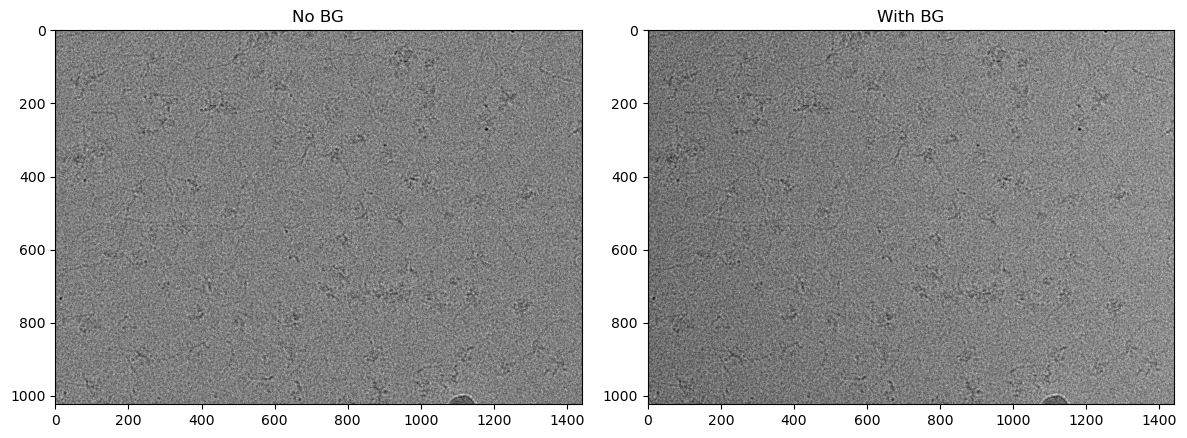

In [4]:
from CryoCRAB.utils.micrograph import background_addition, show_array, estimate_subtract_background
mic_bin1_withBG = background_addition(
    mic_gc_noBG=mic_bin1_noBG,
    bg_bin=BG_bin
) # add background back
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.imshow(show_array(mic_bin1_noBG), cmap='gray')
ax.set_title("No BG")
ax = fig.add_subplot(122)
ax.imshow(show_array(mic_bin1_withBG), cmap='gray')
ax.set_title("With BG")
plt.tight_layout()
plt.show()

## Band-limit to 3 Angstrom & CTF Filtering & Contrast Normalization

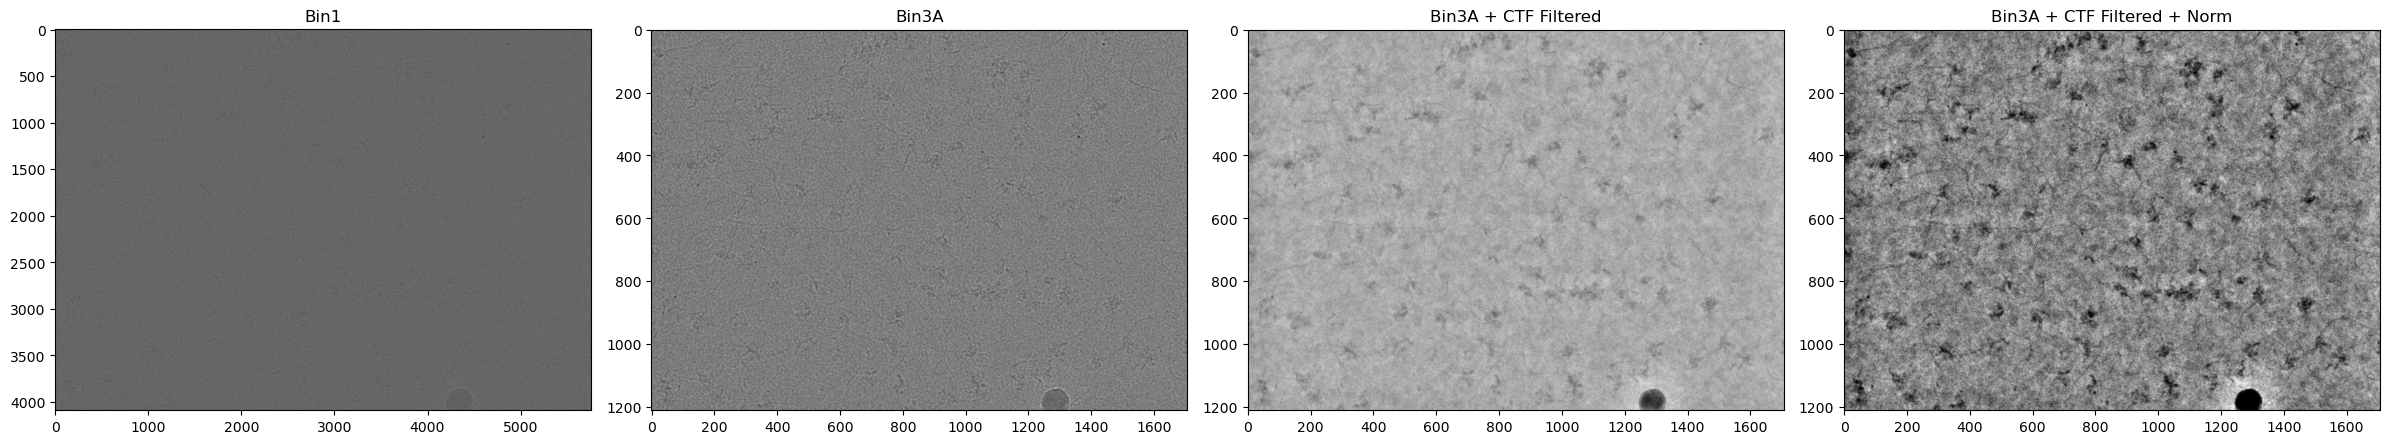

In [ ]:
from CryoCRAB.utils.fft_sizes import get_shapes_for_desired_psize
from CryoCRAB.utils import fft
from CryoCRAB.utils.micrograph import pad_mic_with_mean, trim_mic, contrast_normalization_show, estimate_subtract_background
from CryoCRAB.utils.ctf import compute_ctf

mic_bin1 = mic_bin1_withBG
frame_shape_in = mic_bin1.shape
desired_psize_A = 3.0
N_in, N_out, psize_out, downfactor, frame_shape_out = get_shapes_for_desired_psize(psize_in, frame_shape_in, desired_psize_A)

# subtract background
mic_bin1 = estimate_subtract_background(
    mic_bin1,
    psize=psize_in,
)

do_fcrop = lambda x : fft.ZT( fft.rfft2_center( pad_mic_with_mean(x, N_in) ), N_out )
do_ifft_trim = lambda x : trim_mic( fft.irfft2_center( x ), frame_shape_out)

mic_bin3A_ft = do_fcrop(mic_bin1) # Band-limit to 3 A
freqs_3A = fft.get_rfft_center_freqs((N_out, N_out), psize_out) # Freqs 
ctffilt = compute_ctf( # Prepare CTF Filter
    defocus_u=defocus_u,
    defocus_v=defocus_v,
    defocus_angle_rad=defocus_angle_rad,
    accel_kv=accel_kv,
    cs_mm=cs_mm,
    amp_contrast=amp_contrast,
    phase_shift_rad=phase_shift_rad,
    freqs=freqs_3A,
    N_out=N_out,
    psize_out=psize_out,
)
mic_bin3A_ft_unctfed = mic_bin3A_ft * ctffilt 
mic_bin3A = do_ifft_trim(mic_bin3A_ft) # Only Bin3A 
mic_bin3A_unctfed = do_ifft_trim(mic_bin3A_ft_unctfed) # Bin3A + CTF Filtered
mic_bin3A_unctfed_norm = contrast_normalization_show(mic_bin3A_unctfed) # Bin3A + CTF Filtered + Contrast Normalization

fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(141)
ax.imshow(mic_bin1, cmap='gray')
ax.set_title("Bin1")
ax = fig.add_subplot(142)
ax.imshow(mic_bin3A, cmap='gray')
ax.set_title("Bin3A")
ax = fig.add_subplot(143)
ax.imshow(mic_bin3A_unctfed, cmap='gray')
ax.set_title("Bin3A + CTF Filtered")
ax = fig.add_subplot(144)
ax.imshow(mic_bin3A_unctfed_norm, cmap='gray')
ax.set_title("Bin3A + CTF Filtered + Norm")
plt.tight_layout()
plt.show()